In [23]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
train_dir=r'D:\amazonml\student_resource 3\dataset\train.csv'
df=pd.read_csv(train_dir)

In [3]:
df.head()

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram


In [4]:
df['group_id'].value_counts()

group_id
459516    9458
752266    9063
281678    6137
308856    5437
731432    4741
          ... 
997333       2
656506       2
314298       2
178031       1
226428       1
Name: count, Length: 750, dtype: int64

In [5]:
df['entity_name'].value_counts()

entity_name
item_weight                      102786
depth                             45127
width                             44183
height                            43597
voltage                            9466
wattage                            7755
item_volume                        7682
maximum_weight_recommendation      3263
Name: count, dtype: int64

In [6]:
import os
from pathlib import Path
import urllib
import time

def create_placeholder_image(image_save_path):
    from PIL import Image  
    try:
        placeholder_image = Image.new('RGB', (100, 100), color='black')
        placeholder_image.save(image_save_path)
    except Exception as e:
        print(f"Error creating placeholder image: {e}")
        return

def download_image(image_link, save_folder, retries=3, delay=3):
    if not isinstance(image_link, str):
        print("Invalid image link:", image_link)
        return

    # Ensure the directory exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        print(f"Directory {save_folder} created.")

    filename = Path(image_link).name
    image_save_path = os.path.join(save_folder, filename)

    if os.path.exists(image_save_path):
        print(f"Image already exists: {image_save_path}")
        return

    for attempt in range(retries):
        try:
            print(f"Attempting to download image: {image_link}, attempt {attempt + 1}")
            urllib.request.urlretrieve(image_link, image_save_path)
            print(f"Image successfully downloaded: {image_save_path}")
            return
        except Exception as e:
            print(f"Download failed on attempt {attempt + 1}: {e}")
            time.sleep(delay)
    
    print(f"Failed to download image after {retries} attempts. Creating placeholder image.")
    create_placeholder_image(image_save_path)


In [7]:
for i in range(1,50):
    download_image(image_link=df['image_link'][i],save_folder='images')

Image already exists: images\71gSRbyXmoL.jpg
Image already exists: images\61BZ4zrjZXL.jpg
Image already exists: images\612mrlqiI4L.jpg
Image already exists: images\617Tl40LOXL.jpg
Image already exists: images\61QsBSE7jgL.jpg
Image already exists: images\81xsq6vf2qL.jpg
Image already exists: images\71DiLRHeZdL.jpg
Image already exists: images\91Cma3RzseL.jpg
Image already exists: images\71jBLhmTNlL.jpg
Attempting to download image: https://m.media-amazon.com/images/I/81N73b5khVL.jpg, attempt 1
Image successfully downloaded: images\81N73b5khVL.jpg
Attempting to download image: https://m.media-amazon.com/images/I/61oMj2iXOuL.jpg, attempt 1
Image successfully downloaded: images\61oMj2iXOuL.jpg
Attempting to download image: https://m.media-amazon.com/images/I/91LPf6OjV9L.jpg, attempt 1
Image successfully downloaded: images\91LPf6OjV9L.jpg
Attempting to download image: https://m.media-amazon.com/images/I/81fOxWWWKYL.jpg, attempt 1
Image successfully downloaded: images\81fOxWWWKYL.jpg
Attempt

In [24]:
import cv2
import numpy as np
import os

class ImagePreprocessor:
    
    def __init__(self, contrast_threshold=40, brightness_threshold=120, resize_threshold=300):
        """
        Initialize the preprocessor with thresholds for contrast, brightness, and resizing.
        
        :param contrast_threshold: Minimum contrast value to trigger contrast enhancement.
        :param brightness_threshold: Minimum brightness value to trigger brightness adjustment.
        :param resize_threshold: Minimum height or width to trigger image resizing.
        """
        self.contrast_threshold = contrast_threshold
        self.brightness_threshold = brightness_threshold
        self.resize_threshold = resize_threshold

    def calculate_contrast(self, image):
        """
        Calculate the contrast of the image by measuring the standard deviation of its lightness (L channel).
        
        :param image: Input BGR image.
        :return: Standard deviation of the L channel (contrast metric).
        """
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, _, _ = cv2.split(lab)
        return l_channel.std()

    def calculate_brightness(self, image):
        """
        Calculate the brightness of the image by measuring the mean value of the V (brightness) channel in HSV space.
        
        :param image: Input BGR image.
        :return: Mean value of the V channel (brightness metric).
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        _, _, v = cv2.split(hsv)
        return np.mean(v)

    def preprocess_image(self, image):
        """
        Preprocess the image based on its contrast and brightness. Apply histogram equalization, gamma correction, 
        adaptive thresholding, and resizing if necessary.
        
        :param image: Input BGR image.
        :return: Preprocessed image.
        """
        # Calculate contrast and brightness
        contrast = self.calculate_contrast(image)
        brightness = self.calculate_brightness(image)
        
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Adjust contrast if below threshold
        if contrast < self.contrast_threshold:
            gray_image = cv2.equalizeHist(gray_image)
        
        # Adjust brightness if below threshold
        if brightness < self.brightness_threshold:
            gamma = 1.5  # Example gamma value to increase brightness
            invGamma = 1.0 / gamma
            table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
            gray_image = cv2.LUT(gray_image, table)
        
        # Apply adaptive thresholding for binarization
        binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY, 11, 2)
        
        # Resize image if dimensions are smaller than the resize threshold
        height, width = gray_image.shape
        if height < self.resize_threshold or width < self.resize_threshold:
            binary_image = cv2.resize(binary_image, (width * 2, height * 2), interpolation=cv2.INTER_CUBIC)
        
        return binary_image

    def batch_preprocess_images(self, image_folder, output_folder):
        """
        Process all images in a given folder using the preprocess_image function and save the results.
        
        :param image_folder: Folder containing input images.
        :param output_folder: Folder where the preprocessed images will be saved.
        """
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        for filename in os.listdir(image_folder):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Preprocess the image
                    preprocessed_image = self.preprocess_image(image)
                    
                    # Save the preprocessed image
                    output_path = os.path.join(output_folder, filename)
                    cv2.imwrite(output_path, preprocessed_image)
                    print(f"Processed and saved: {filename}")
                else:
                    print(f"Could not open: {filename}")



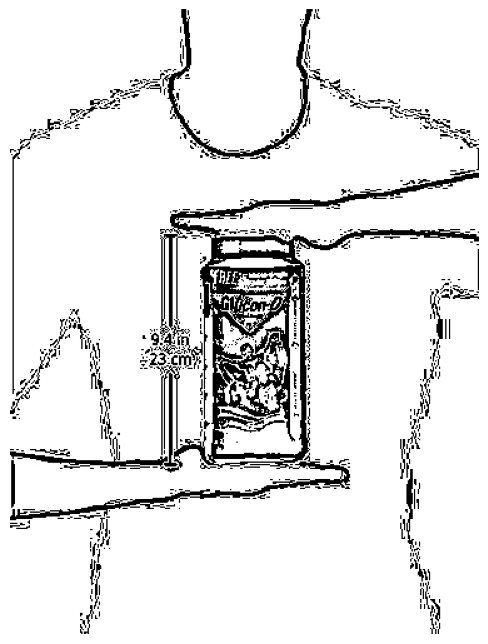

In [26]:
preprocessor = ImagePreprocessor(contrast_threshold=40, brightness_threshold=120, resize_threshold=300)
image = cv2.imread(r'images\31EvJszFVfL.jpg')
preprocessed_image = preprocessor.preprocess_image(image)
cv2.imwrite('new-temp-image/new1.jpg',preprocessed_image)
display('new-temp-image/new1.jpg')


In [27]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Update this path
text = pytesseract.image_to_string(r'images\31EvJszFVfL.jpg').strip()

In [31]:
text

'9.4in\n23cm'

In [8]:
def caculate_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    return l_channel.std()

In [17]:
def calculate_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    return np.mean(v)

In [ ]:
def preprocess_image(local_image_path):
    if not isinstance(local_image_path,str):
        print("Not a valid path")
    else:
        # preprocessing of image should be performed , and image should be stored somewhere in a new directory
        contrast = calculate_contrast(image)
        brightness = calculate_brightness(image)
        
        

In [40]:
def read_text_from_image(local_image_path):
    if not isinstance(local_image_path,str):
        print("Please give a valid image path")
        # returning nan if the path is invalic
        return np.nan
    else:
        import pytesseract
        try:
            pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Update this path

            from PIL import Image
            img=Image.open(local_image_path)
            text = pytesseract.image_to_string(img).strip()
            if not text:  # Check if the text is empty after stripping
                print(f"No text could be extracted from {local_image_path}")
                # the below code should work for 62mrl
                rotated_img=img.rotate(270,expand=True)
                text = pytesseract.image_to_string(rotated_img).strip()
                if not text:  # Still no text after rotation
                    print(f"No text could be extracted from {local_image_path} even after rotation.")
                    return np.nan
                else:
                    print(f"Text extracted after rotating {local_image_path}:\n{text}\n")
                    return text
            else:
                print(f"Text extracted from {local_image_path}:\n{text}\n")
                return text
            
        except Exception as e:
            print(f"Error processing {local_image_path}: {e}")
            return np.nan 

In [22]:
def return_all_file_names(directory_path):
    """
    Return all corresponding Image paths of a directory
    """
    if not isinstance(directory_path,str):
        print("Not a valid path")
        return 
    try:
        for file_name in os.listdir(directory_path):
            full_path=os.path.join(directory_path,file_name)
            if os.path.isfile(full_path):
                yield os.path.join('images',file_name)
                
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [41]:
def create_image_text_dataframe(directory_path):
    data={"Image Path":[],"Extracted Text":[]}
    for file_name in return_all_file_names(directory_path):
        text = read_text_from_image(file_name)  
        data["Image Path"].append(file_name)    
        data["Extracted Text"].append(text)
    df = pd.DataFrame(data)
    return df

In [42]:
directory_path = r'D:\amazonml\student_resource 3\approach\images'

# Create the DataFrame
df = create_image_text_dataframe(directory_path)

# Display the DataFrame
print(df)

No text could be extracted from images\612mrlqiI4L.jpg
Text extracted after rotating images\612mrlqiI4L.jpg:
COMPOSITION
Serving Size: 1 Tablet (0.709 g) | Each serving contains (Approx. Values):

‘Kutki Picrorhiza kurroa) rhizome extract ~ 0.5z Biers
Kasani (Cichorium endiva) seed extract ~ 1% Bitters
Punarnava (Boerhavia diffusa) root extract - 0.07% alkaloids
Bhui amla (Phyllanthus amarus) WP extract 0.5% Bitters
‘Amla (Phyllanthes emblica) fruit extract ~ 102 Tannins

Wissel

{IRDA values established as per ICMR 2010 for sedentary Utesye-Hen.
STTRDA nt established by ICMR
Dopraprite overages of amin ded to compensate las of potency rng storage

oie nares: Baking aget 0 Disintgrct INS 12028 NS AS Binder IS 1201, An-sicking agent KS 470
(Gi, An-cakng agent DS 51. lazing agent INS 553 Gl. Coating agent NS 46)

{CONTAINS PERHITED SYNTHETIC FODO COLOURS DNS 1711S 1726, NS 1726) & NS 17261

Recommended Usage 1 Tablet per day or as suggested by the dietian,
‘Warning: Consut your physician

In [43]:
df

,Image Path,Extracted Text
0,images\612mrlqiI4L.jpg,COMPOSITION\nServing Size: 1 Tablet (0.709 g) ...
1,images\617Tl40LOXL.jpg,HIGH STRENGTH\n\nPSYLLIUM\n\nHUSK
2,images\61BZ4zrjZXL.jpg,Serving Size: 1 Tablet (0.709 g) | Each servin...
3,images\61I9XdN6OFL.jpg,100% NATUR
4,images\61QsBSE7jgL.jpg,¢ Naturally-Sourced Psyllium\n\n—_\n\n* High s...
5,images\71DiLRHeZdL.jpg,©)\n\nVEGAN\n\nWO\n\nWHEAT\nFREE\n\nSOY\n\npsy...
6,images\71gSRbyXmoL.jpg,GEPRAGTES\n\nDesigned in\n\nLIZENZIERTE UND GE...
7,images\71jBLhmTNlL.jpg,NEW LOOK.\nSAME Nea LES QUALITY.\n\nMame PSYLL...
8,images\81xsq6vf2qL.jpg,"Directions: For adults, take two (2) vegan cap..."
9,images\91Cma3RzseL.jpg,Horbaach\n\n100%\n\nHIGHEST\nQUALITY\n\nHIGH S...


In [61]:
df

,Image Path,Extracted Text
0,images\612mrlqiI4L.jpg,COMPOSITION\nServing Size: 1 Tablet (0.709 g) ...
1,images\617Tl40LOXL.jpg,HIGH STRENGTH\n\nPSYLLIUM\n\nHUSK
2,images\61BZ4zrjZXL.jpg,Serving Size: 1 Tablet (0.709 g) | Each servin...
3,images\61I9XdN6OFL.jpg,100% NATUR
4,images\61QsBSE7jgL.jpg,¢ Naturally-Sourced Psyllium\n\n—_\n\n* High s...
5,images\71DiLRHeZdL.jpg,©)\n\nVEGAN\n\nWO\n\nWHEAT\nFREE\n\nSOY\n\npsy...
6,images\71gSRbyXmoL.jpg,GEPRAGTES\n\nDesigned in\n\nLIZENZIERTE UND GE...
7,images\71jBLhmTNlL.jpg,NEW LOOK.\nSAME Nea LES QUALITY.\n\nMame PSYLL...
8,images\81xsq6vf2qL.jpg,"Directions: For adults, take two (2) vegan cap..."
9,images\91Cma3RzseL.jpg,Horbaach\n\n100%\n\nHIGHEST\nQUALITY\n\nHIGH S...


In [62]:
try:
    df.to_csv('extracted_text2.csv',index=False)
except Exception as e:
    print("Sorry an exception occured")

In [27]:
import re
import numpy as np
import pandas as pd

def extract_all_numbers_and_words(text):
    """
    args:
    :text -> It should be the extracted text column in dataframe, 
    Here I am trying to keep only the numbers present and next words (Hope, it's accurate)
    """
    if not isinstance(text, str):
        return np.nan
    
    # Regex to match any number followed by one or more words
    pattern = r'(\d+[\.\d+]*)\s*(\w+)(?:\s+(\w+))?'
    matches = re.findall(pattern, text)
    
    if matches:
        # Flatten the matches into a string format "number unit"
        result = []
        for match in matches:
            result.append(' '.join([part for part in match if part]))  # Join number and following words
        return ' '.join(result)  # Return all matches as a single string
    return np.nan



1 Tablet 0.709 g 200 mg Dandelion 1 0 1 100 mg 0. 5 50 mg Kasani 25 mg Punarnava 0.0 7 25 mg Bhui 0. 5 25 mg Amla 1 0 25 mg Licorice 25 mg Vitamin 10 mg Piper 9 5 5 mg Nutrients 3.04 kcal Carbohydrate 051 g 02 g Protein 0.049 Fat 0 09 g


In [28]:
df['Extracted Text']=df['Extracted Text'].apply(extract_all_numbers_and_words)

In [29]:
df

,Image Path,Extracted Text
0,images\612mrlqiI4L.jpg,NaN
1,images\617Tl40LOXL.jpg,NaN
2,images\61BZ4zrjZXL.jpg,NaN
3,images\61I9XdN6OFL.jpg,NaN
4,images\61QsBSE7jgL.jpg,NaN
5,images\71DiLRHeZdL.jpg,NaN
6,images\71gSRbyXmoL.jpg,NaN
7,images\71jBLhmTNlL.jpg,NaN
8,images\81xsq6vf2qL.jpg,NaN
9,images\91Cma3RzseL.jpg,NaN


In [47]:
import cv2

In [48]:
img = cv2.imread(r'images\617Tl40LOXL.jpg')


In [52]:
text

'PSYLLIUM\n\nHUSK\nPLANTSEEDS'

In [ ]:
img=Image.open(r'images\617Tl40LOXL.jpg')
